In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib as plt
import stock_utils as su
import trader as tr
import signaller as sg
import seaborn as sns

from sklearn.externals import joblib

%matplotlib inline

## Choose a ticker symbol and generate a dataset with selected new features for it

In [2]:
#create a dataset for AAPL
rs = 42 # random state
tickers = ['AAPL', 'XOM']
symbol = tickers[0]
window = 5
look_ahead = 1

start_date = datetime.datetime(2017, 4, 1)
end_date = datetime.datetime(2017, 8, 31)

## Load saved models

In [3]:
import os
model_filenames = []
for file in os.listdir('models'):
    if file.endswith('.pkl'):
        model_filenames.append(file)

estimators = []
for filename in model_filenames:
    estimators.append(joblib.load('models/{0}'.format(filename)))

## Load stock data and calculate predictions

In [4]:
dataset = su.preprocess_data(symbol, window, look_ahead, start_date, end_date)

#calculate the predicted prices
pred = su.calculate_predictions_for_dataset(dataset=dataset, estimators=estimators, plot_and_print=False)

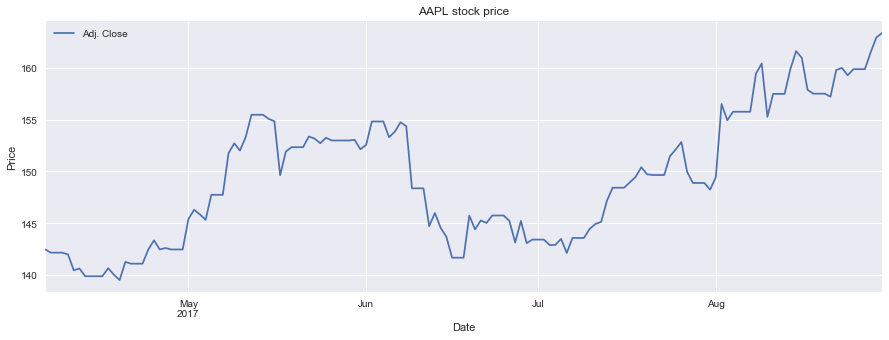

In [5]:
data_frame = dataset[['Adj. Close']]
ax = data_frame.plot(figsize=(15,5), grid=True, title='{0} stock price'.format(symbol))

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')

## Calculate trade signals based on the predictions

In [6]:
#add the predicted prices to the dataset
dataset['Predicted Price'] = pred

#price variation in percentage which can inform trade decisions
delta = 0.01

signaller_params = {'delta' : delta}

#calculate trade signals based on different indicators and add those signals to the dataframe
signaller = sg.Signaller(signaller_params)

dataset = signaller.calculate_trade_signal(dataset)

dataset.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price,Predicted Price,RM Signal,Percentage Signal,BB Signal,Trade Signal
2017-04-06,143.121231,143.349367,142.288035,142.496334,-0.002500,142.803823,141.871015,143.736630,-0.000278,142.178926,142.531981,0,0,0,0
2017-04-07,142.565767,143.012122,142.109493,142.178926,-0.002227,142.732406,141.653795,143.811016,-0.002505,142.178926,142.239182,0,0,0,0
2017-04-08,142.565767,143.012122,142.109493,142.178926,0.000000,142.660989,141.475380,143.846598,-0.002505,142.178926,142.265886,0,0,0,0
2017-04-09,142.565767,143.012122,142.109493,142.178926,0.000000,142.377306,141.778211,142.976400,-0.009878,142.010303,142.261262,0,0,0,0
2017-04-10,142.436820,142.713758,141.742490,142.010303,-0.001186,142.208683,141.855477,142.561888,-0.005902,140.482777,142.002420,0,0,0,0


In [7]:
dataset.describe()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price,Predicted Price,RM Signal,Percentage Signal,BB Signal,Trade Signal
count,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.0,147.0,147.000000
mean,149.497853,150.460596,148.422818,149.449477,0.000963,149.184013,146.809744,151.558282,0.004405,149.595761,149.425771,0.000000,0.0,0.0,0.000000
std,6.250456,6.374856,6.181546,6.306528,0.010113,6.020646,5.773437,6.680009,0.020905,6.392944,6.301960,0.202721,0.0,0.0,0.202721
min,140.076098,140.730752,138.925494,139.540472,-0.038777,140.018568,138.870204,140.721647,-0.064684,139.540472,139.673384,-1.000000,0.0,0.0,-1.000000
25%,143.866270,144.458866,142.551654,143.552543,-0.002034,143.508721,141.898717,145.570677,-0.005329,143.597361,143.490305,0.000000,0.0,0.0,0.000000
50%,149.284287,149.832064,147.822836,148.895863,0.000000,149.401810,145.406147,150.799293,0.004739,148.955620,149.137338,0.000000,0.0,0.0,0.000000
75%,154.174445,154.866637,152.999214,154.781980,0.004829,153.434448,152.012930,156.687698,0.016477,154.821818,154.243646,0.000000,0.0,0.0,0.000000
max,163.800000,163.890000,162.610000,163.350000,0.047251,161.490000,159.201801,164.774844,0.052221,164.000000,163.313224,1.000000,0.0,0.0,1.000000


## Define trading strategies based on the generated trade signals

In [8]:
#risk behaviour levels for buying stocks: the higher the value, the higher the confidence that the signal is correct
buy_risk_levels = {'high' : 1, 'moderate' : 2, 'low' : 3}

#risk behaviour levels for selling stocks: the lower the value, the higher the confidence that the signal is correct
sell_risk_levels = {'low' : -3, 'moderate' : -2, 'high' : -1}

debug_flag = True

initial_funds = 100000

trader_configurations = [\
                         #balanced trader
                         {'name' : 'Balanced Trader', \
                          'buy_risk' : buy_risk_levels['moderate'], \
                          'sell_risk' : sell_risk_levels['moderate'], \
                          'use_signal_strength' : True, \
                          'initial_funds' : initial_funds, \
                          'debug' : debug_flag \
                         },\
                         #bearish trader
                         {'name' : 'Bearish Trader', \
                          'buy_risk' : buy_risk_levels['low'], \
                          'sell_risk' : sell_risk_levels['high'], \
                          'use_signal_strength' : True,
                          'initial_funds' : initial_funds, \
                          'debug' : debug_flag \
                         },\
                         #bullish trader
                         {'name' : 'Bullish Trader', \
                          'buy_risk' : buy_risk_levels['high'], \
                          'sell_risk' : sell_risk_levels['low'], \
                          'use_signal_strength' : True, \
                          'initial_funds' : initial_funds, \
                          'debug' : debug_flag \
                         }\
                        ]

## Find the best trading strategy for the given stock data

In [9]:
trade_df = dataset[['Adj. Close', 'Trade Signal']]

highest_profit = -100
best_trader = None

for config in trader_configurations:
    trader = tr.Trader(config)
    trader.trade(trade_df)
    
    if trader.profit > highest_profit:
        highest_profit = trader.profit
        best_trader = config['name']
    
print('Best trader for this {0} stock market data is : {1}'.format(symbol, best_trader))

Balanced Trader starts trading
Balanced Trader enters position by buying 300.0 stocks at 142.50$ and has 57251.10$ left to invest
First vs Last adjusted close: 142.50 vs 163.35
After 0 transactions, Balanced Trader has 300.0 stocks and 57251.10$ left in funds
Balanced Trader exits his position with a profit of 6.26%

Bearish Trader starts trading
Bearish Trader enters position by buying 300.0 stocks at 142.50$ and has 57251.10$ left to invest
Bearish Trader sells 100 stocks for 15298.93 $ on 2017-05-28 00:00:00
Bearish Trader sells 100 stocks for 14524.07 $ on 2017-06-28 00:00:00
Bearish Trader sells 100 stocks for 14966.28 $ on 2017-07-21 00:00:00
First vs Last adjusted close: 142.50 vs 163.35
After 3 transactions, Bearish Trader has 0.0 stocks and 102040.37$ left in funds
Bearish Trader exits his position with a profit of 2.04%

Bullish Trader starts trading
Bullish Trader enters position by buying 300.0 stocks at 142.50$ and has 57251.10$ left to invest
Bullish Trader buys 100 stock

## Let's test for another stock

In [10]:
symbol = tickers[1]

start_date2 = datetime.datetime(2015, 1, 1)
end_date2 = datetime.datetime(2015, 6, 30)

dataset2 = su.preprocess_data(symbol, window, look_ahead, start_date2, end_date2)

data2 = dataset2.drop(labels=['Future Price'], axis=1)
target2 = dataset2['Future Price']

dataset2.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price
2015-01-06,81.143242,82.195299,80.046226,80.756589,-0.005316,82.472251,79.716947,85.227554,-0.032533,81.574855
2015-01-07,81.511912,82.258243,80.927436,81.574855,0.010133,82.092791,79.508752,84.676830,-0.022730,82.932638
2015-01-08,82.051428,82.968606,81.826630,82.932638,0.016645,81.984888,79.656424,84.313352,-0.006463,82.815743
2015-01-09,82.995582,83.427195,82.159331,82.815743,-0.001410,81.853605,79.900678,83.806533,-0.007864,82.815743
2015-01-10,82.995582,83.427195,82.159331,82.815743,0.000000,82.179114,80.238213,84.120014,0.020047,82.815743


In [11]:
dataset2.describe()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price
count,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000
mean,79.196476,79.694861,78.609711,79.158041,-0.000366,79.230321,78.075680,80.384962,-0.002193,79.130924
std,2.227115,2.241858,2.132685,2.277972,0.008627,2.200713,2.078404,2.560836,0.018044,2.287060
min,75.685113,76.147160,74.905975,75.663993,-0.032985,76.074682,74.581539,76.353922,-0.047297,75.663993
25%,77.343046,77.879006,76.793120,77.363281,-0.004356,77.229896,76.195642,78.130033,-0.014351,77.339574
50%,78.991920,79.506710,78.511753,78.828845,0.000000,79.017287,78.116425,79.953860,-0.002524,78.792606
75%,80.873956,81.456171,80.022024,80.667220,0.000916,80.938029,79.521876,82.236554,0.008532,80.631734
max,84.029138,84.663321,83.612390,84.590843,0.029806,84.532860,84.273555,86.580640,0.056509,84.590843


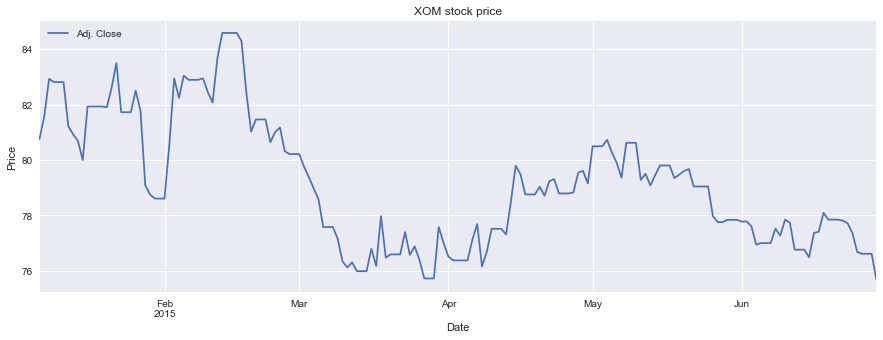

In [12]:
data_frame = data2[['Adj. Close']]

ax = data_frame.plot(figsize=(15,5), grid=True, title='{0} stock price'.format(symbol))

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')

In [13]:
dataset2 = su.preprocess_data(symbol, window, look_ahead, start_date2, end_date2)

pred2 = su.calculate_predictions_for_dataset(dataset=dataset2, estimators=estimators, plot_and_print=False)

dataset2['Predicted Price'] = pred2

dataset2 = signaller.calculate_trade_signal(dataset2)

dataset2_df = dataset2[['Adj. Close', 'Trade Signal']]

highest_profit = -100
best_trader = None

for config in trader_configurations:
    trader = tr.Trader(config)
    trader.trade(dataset2_df)
    
    if trader.profit > highest_profit:
        highest_profit = trader.profit
        best_trader = config['name']
    
print('Best trader for this {0} stock market data is : {1}'.format(symbol, best_trader))

Balanced Trader starts trading
Balanced Trader enters position by buying 600.0 stocks at 80.76$ and has 51546.05$ left to invest
First vs Last adjusted close: 80.76 vs 75.66
After 0 transactions, Balanced Trader has 600.0 stocks and 51546.05$ left in funds
Balanced Trader exits his position with a profit of -3.06%

Bearish Trader starts trading
Bearish Trader enters position by buying 600.0 stocks at 80.76$ and has 51546.05$ left to invest
Bearish Trader sells 100 stocks for 8459.08 $ on 2015-02-16 00:00:00
Bearish Trader sells 100 stocks for 8117.53 $ on 2015-02-25 00:00:00
Bearish Trader sells 100 stocks for 7783.84 $ on 2015-05-30 00:00:00
First vs Last adjusted close: 80.76 vs 75.66
After 3 transactions, Bearish Trader has 300.0 stocks and 75906.50$ left in funds
Bearish Trader exits his position with a profit of -1.39%

Bullish Trader starts trading
Bullish Trader enters position by buying 600.0 stocks at 80.76$ and has 51546.05$ left to invest
Bullish Trader buys 100 stocks for 7